# How to use SAM model 

https://blog.roboflow.com/how-to-use-segment-anything-model-sam/

https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [4]:
import os
import argparse
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import supervision as sp
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
img_path = os.path.join(os.getcwd(), 'testimgs', 'image_0001.jpg')

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

MODEL_TYPE = 'vit_h'
SAM_CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints', 'sam_vit_h_4b8939.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(device=device)
sam.to(device=device)

masks_generator = SamAutomaticMaskGenerator(sam)

masks = masks_generator.generate(img)

In [ ]:
# NOT WORKING

mask_annotator = sp.MaskAnnotator()

detections = sp.Detections.from_sam(masks)

annotated_img = mask_annotator.annotate(img, detections)

In [7]:
print(len(masks))
print(type(masks))

print(img.shape)
print(164*398)

46
<class 'list'>
(164, 398, 3)
65272


In [ ]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

seg_masks = []


for idx, i in enumerate(masks):
    print(idx, i)
    seg_mask = i['segmentation']
    seg_mask = np.array(seg_mask * 255).astype('uint8')
    seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_GRAY2BGR)
    seg_masks.append(seg_mask)

    box = i['bbox']
    x0, y0, w, h = box
    crop = img[y0:y0+h, x0:x0+w]
    # cv2.imwrite(f'crop_{idx}.jpg', crop)


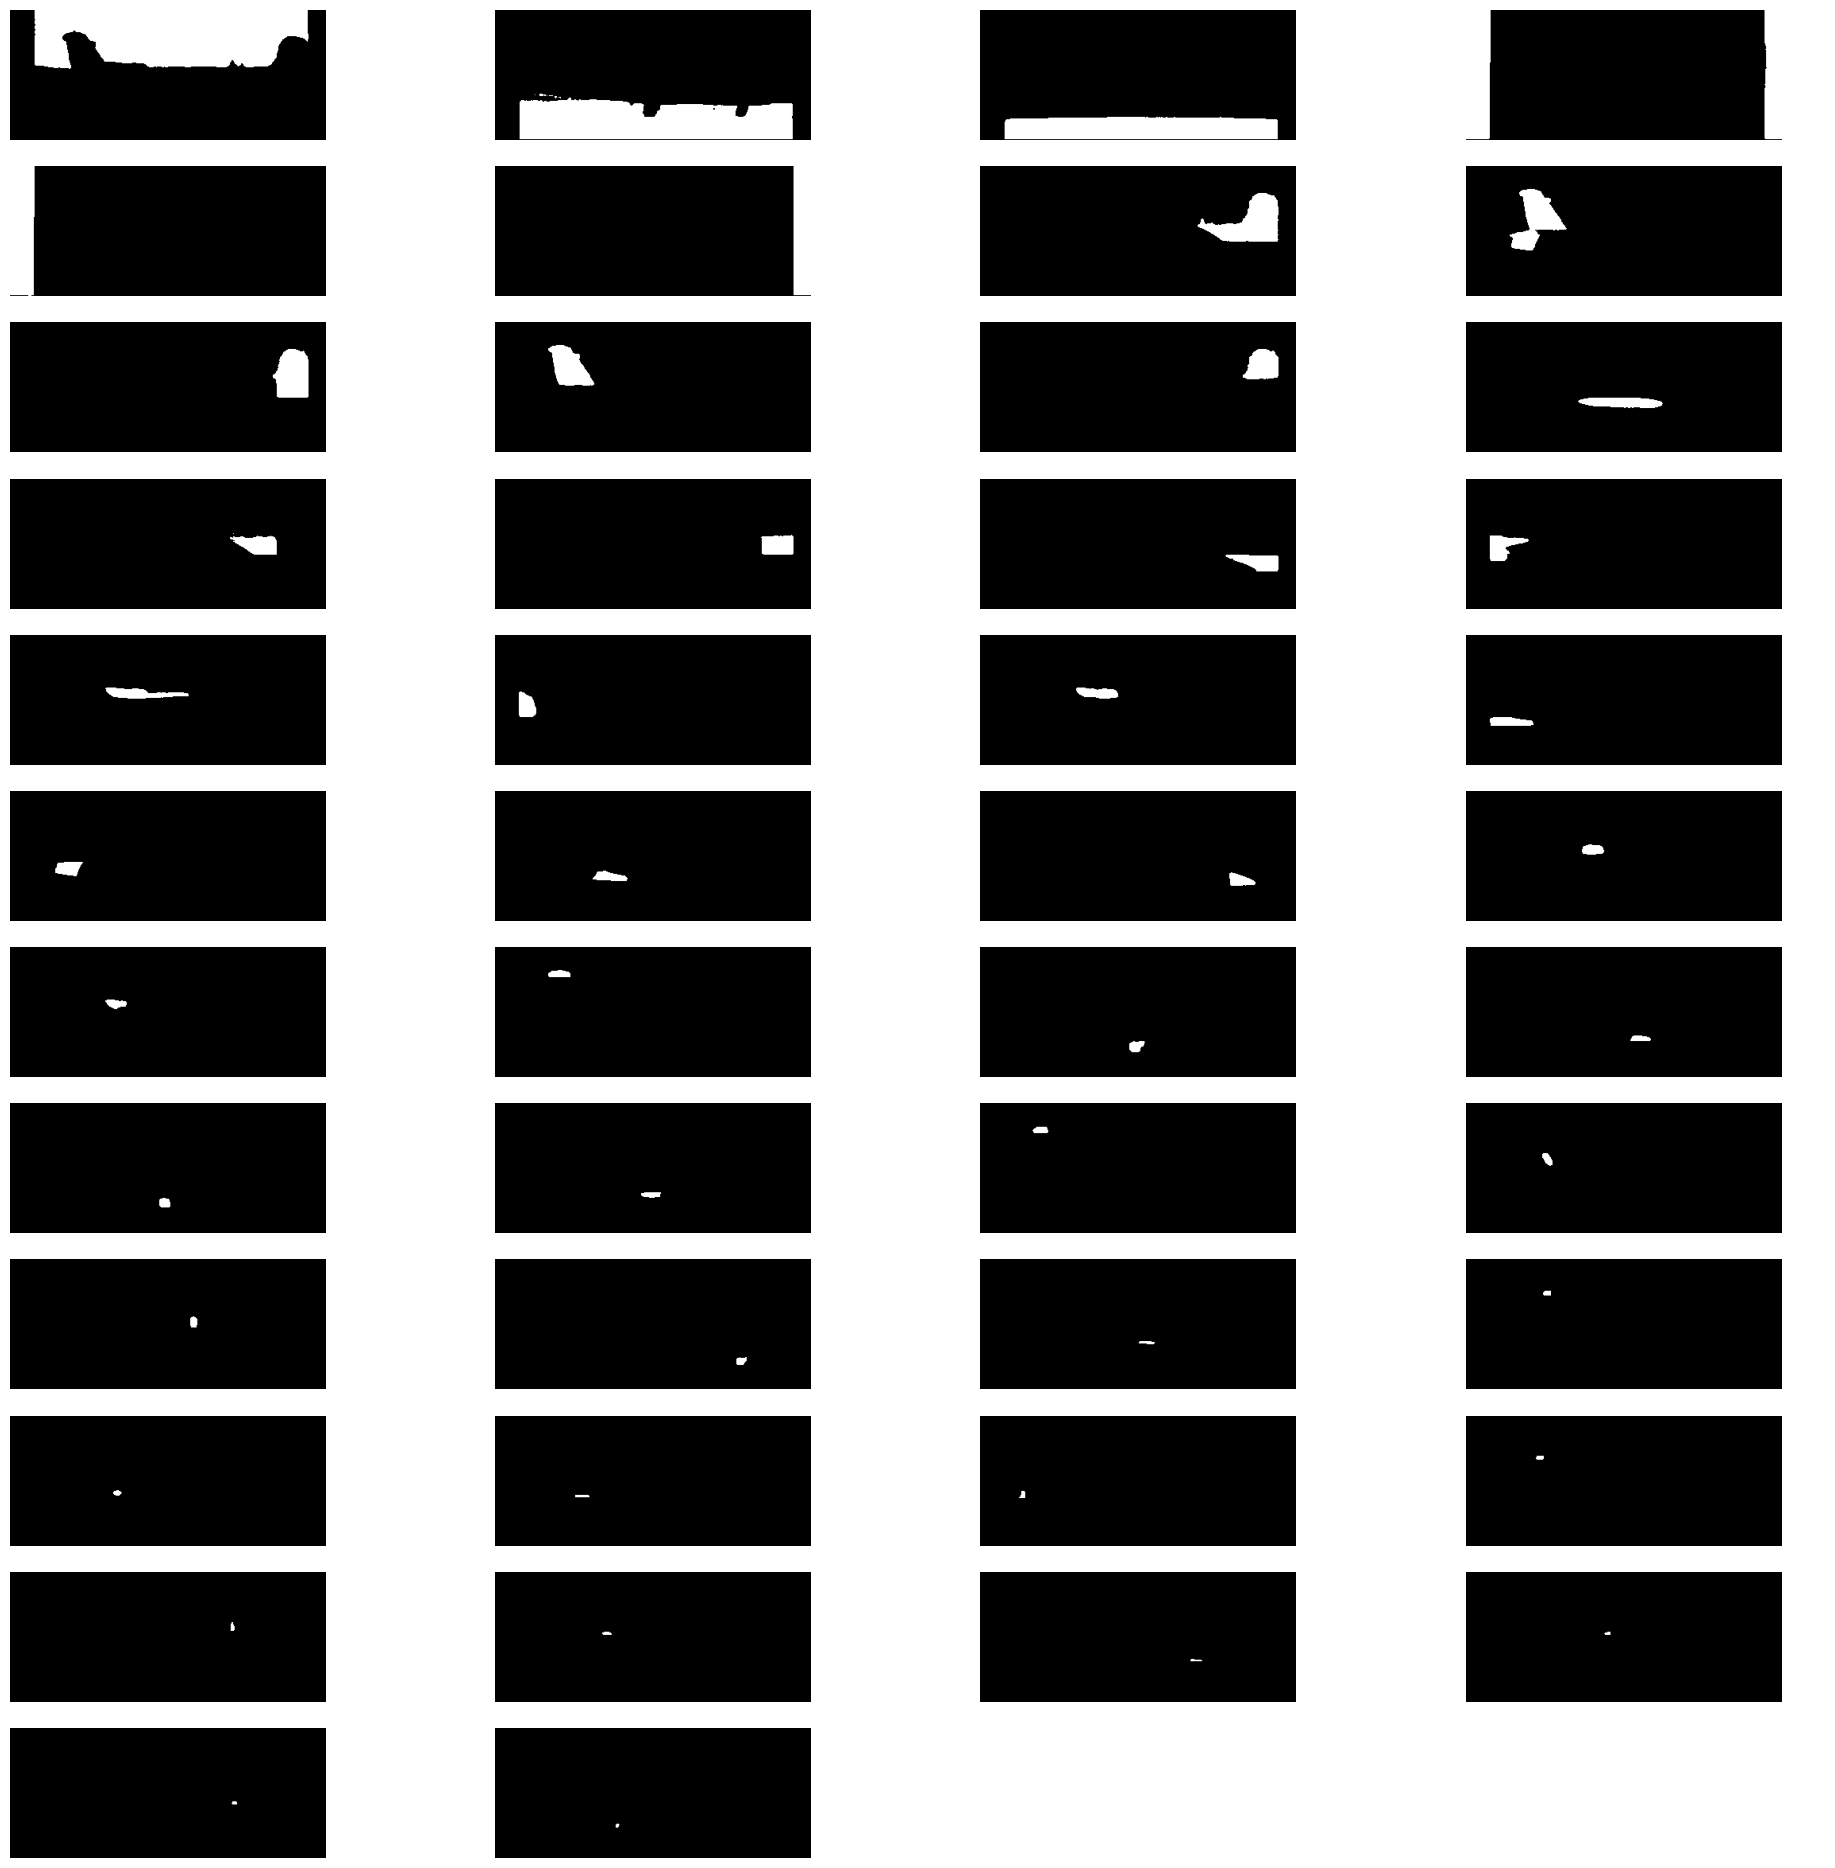

In [9]:
sp.plot_images_grid(
    images=seg_masks,
    grid_size=(12, 4),
    size=(24, 24)
)

In [10]:
def show_all_masks(masks):
    sorted_masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones(
        (
            sorted_masks[0]["segmentation"].shape[0],
            sorted_masks[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for mask in sorted_masks:
        m = mask["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


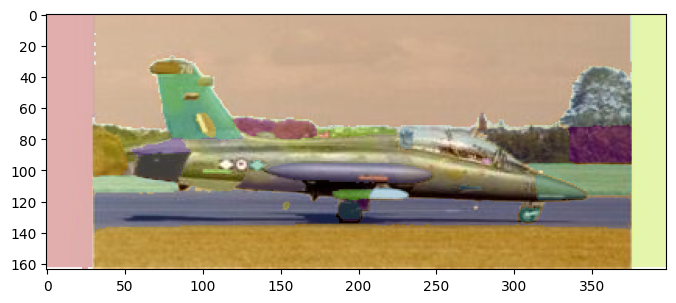

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
show_all_masks(masks)